In [ ]:
# 🚦 Spatio-Temporal Traffic Forecasting with GNN

**Goal:** Predict traffic volume 15 minutes ahead using sensor data from 36 locations.

- We use a Graph Neural Network (GNN) leveraging the spatial relationships (adjacency matrix).
- Each input sample is a `(36, 48)` matrix: 48 features per sensor.
- We use PyTorch Geometric to apply GNN layers.
- Output is traffic volume at each sensor (36 values).

**Dataset:** Provided `.mat` file contains:
- `tra_X_tr` / `tra_X_te`: list of sparse matrices (CSC) with shape `(36, 48)` per sample
- `tra_Y_tr` / `tra_Y_te`: ground truth targets of shape `(36, N)` (volume at each sensor)
- `tra_adj_mat`: (36, 36) adjacency matrix representing sensor connectivity

**Steps:**
1. Load and reshape the data
2. Build a GNN using PyTorch Geometric
3. Train and evaluate the model

In [1]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
# !pip install scipy scikit-learn numpy

In [23]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
#!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
#!pip install scipy scikit-learn matplotlib seaborn networkx

In [24]:
import scipy.io
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

mat = scipy.io.loadmat('traffic_dataset.mat')

# Convert sparse lists to dense [samples, sensors, features]
def convert_sparse_list(sparse_list):
    return np.stack([s.toarray() for s in sparse_list], axis=0)

X_tr = convert_sparse_list(mat['tra_X_tr'][0])  # (1261, 36, 48)
X_te = convert_sparse_list(mat['tra_X_te'][0])  # (840, 36, 48)
Y_tr = mat['tra_Y_tr'].T  # (1261, 36)
Y_te = mat['tra_Y_te'].T  # (840, 36)
adj = mat['tra_adj_mat']  # (36, 36)

print('X_tr:', X_tr.shape, 'Y_tr:', Y_tr.shape)
print('Adjacency:', adj.shape)

X_tr: (1261, 36, 48) Y_tr: (1261, 36)
Adjacency: (36, 36)


In [25]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Prepare edge index from adjacency
edge_index = torch.tensor(np.array(np.nonzero(adj)), dtype=torch.long)

# Create PyTorch Geometric Data objects per sample
def create_data_list(X, Y):
    data_list = []
    for x_sample, y_sample in zip(X, Y):
        x_tensor = torch.tensor(x_sample, dtype=torch.float32)  # (36, 48)
        y_tensor = torch.tensor(y_sample, dtype=torch.float32)  # (36,)
        data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)
        data_list.append(data)
    return data_list

train_data = create_data_list(X_tr, Y_tr)
test_data = create_data_list(X_te, Y_te)

In [26]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x.squeeze()

model = GCN(in_channels=48, hidden_channels=64, out_channels=1)
print(model)

GCN(
  (conv1): GCNConv(48, 64)
  (conv2): GCNConv(64, 1)
)


In [27]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

device = torch.device('cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(1, 21):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 0.0793
Epoch 2, Loss: 0.0154
Epoch 3, Loss: 0.0098
Epoch 4, Loss: 0.0088
Epoch 5, Loss: 0.0082
Epoch 6, Loss: 0.0077
Epoch 7, Loss: 0.0073
Epoch 8, Loss: 0.0070
Epoch 9, Loss: 0.0068
Epoch 10, Loss: 0.0066
Epoch 11, Loss: 0.0064
Epoch 12, Loss: 0.0063
Epoch 13, Loss: 0.0062
Epoch 14, Loss: 0.0061
Epoch 15, Loss: 0.0060
Epoch 16, Loss: 0.0060
Epoch 17, Loss: 0.0060
Epoch 18, Loss: 0.0059
Epoch 19, Loss: 0.0059
Epoch 20, Loss: 0.0058


In [28]:
model.eval()
total_mse = 0
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred = model(batch)
        loss = loss_fn(pred, batch.y)
        total_mse += loss.item() * batch.num_graphs
print(f"Test MSE: {total_mse / len(test_loader.dataset):.4f}")

Test MSE: 0.0064


In [29]:
import matplotlib.pyplot as plt
import networkx as nx

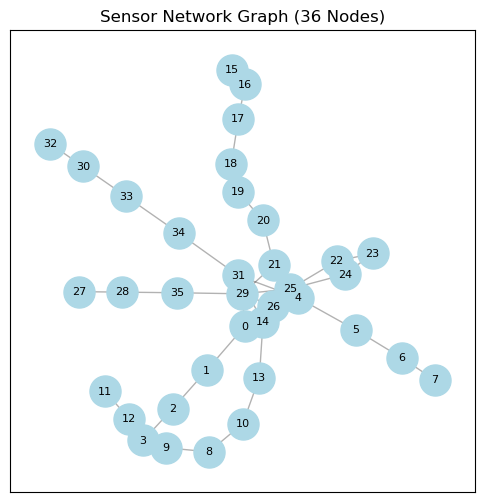

In [33]:
# Plot adjacency matrix as a graph
def plot_sensor_graph(adj_matrix):
    G = nx.from_numpy_array(adj_matrix)
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(6,6))
    nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=500)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title("Sensor Network Graph (36 Nodes)")
    plt.show()

plot_sensor_graph(adj)

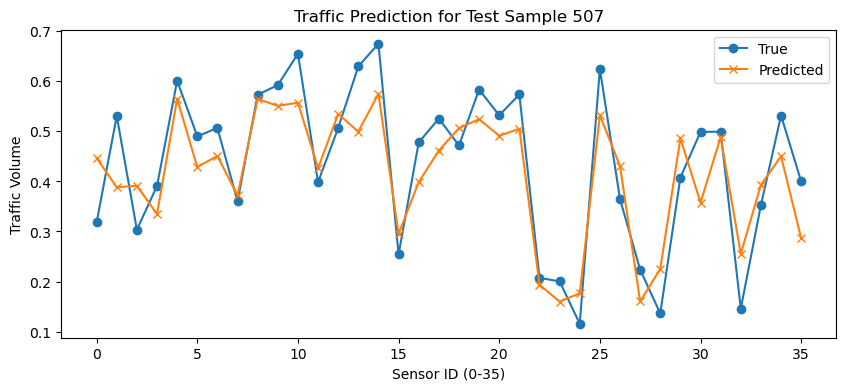

In [34]:
import random

# Pick a random test sample
sample_idx = random.randint(0, len(test_data)-1)
sample = test_data[sample_idx].to(device)

model.eval()
with torch.no_grad():
    pred = model(sample).cpu().numpy()
true = sample.y.cpu().numpy()

# Plot true vs predicted for each sensor
plt.figure(figsize=(10,4))
plt.plot(true, label="True", marker='o')
plt.plot(pred, label="Predicted", marker='x')
plt.xlabel("Sensor ID (0-35)")
plt.ylabel("Traffic Volume")
plt.legend()
plt.title(f"Traffic Prediction for Test Sample {sample_idx}")
plt.show()


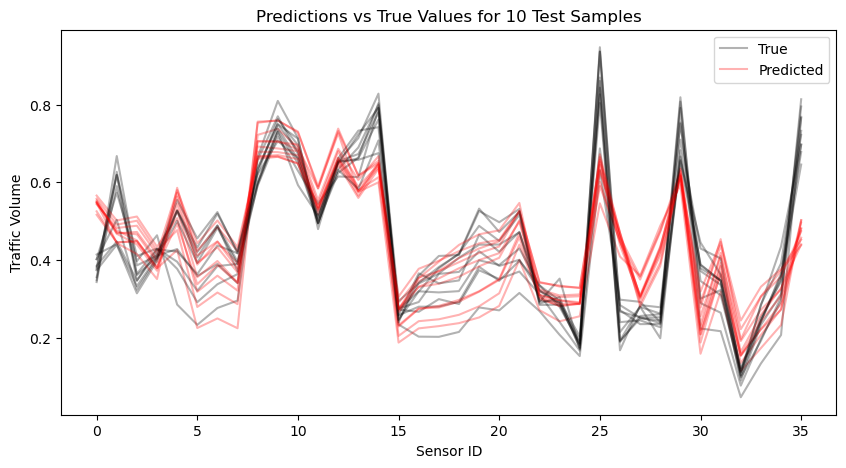

In [35]:
num_samples = 10
plt.figure(figsize=(10,5))

for i in range(num_samples):
    sample = test_data[i].to(device)
    with torch.no_grad():
        pred = model(sample).cpu().numpy()
    true = sample.y.cpu().numpy()

    plt.plot(true, color="black", alpha=0.3, label="True" if i==0 else "")
    plt.plot(pred, color="red", alpha=0.3, label="Predicted" if i==0 else "")

plt.legend()
plt.title(f"Predictions vs True Values for {num_samples} Test Samples")
plt.xlabel("Sensor ID")
plt.ylabel("Traffic Volume")
plt.show()

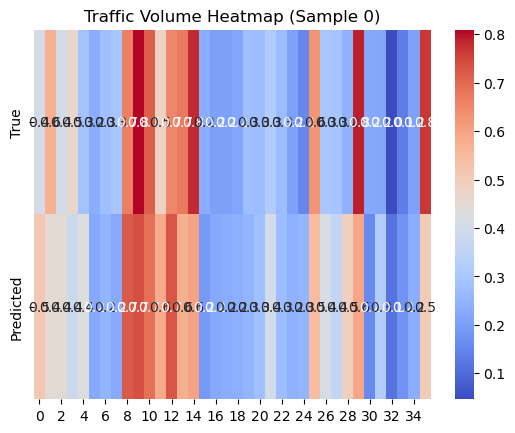

In [36]:
import seaborn as sns

# Single sample heatmap
sample_idx = 0
sample = test_data[sample_idx].to(device)

with torch.no_grad():
    pred = model(sample).cpu().numpy()

true = sample.y.cpu().numpy()

sns.heatmap(
    np.vstack([true, pred]),
    annot=True,
    fmt=".1f",
    cmap="coolwarm",
    yticklabels=["True", "Predicted"]
)
plt.title(f"Traffic Volume Heatmap (Sample {sample_idx})")
plt.show()


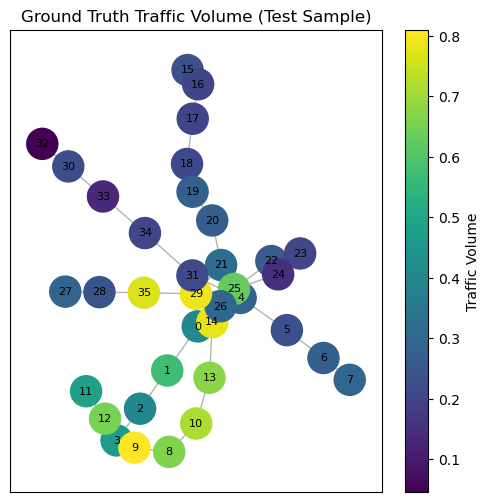

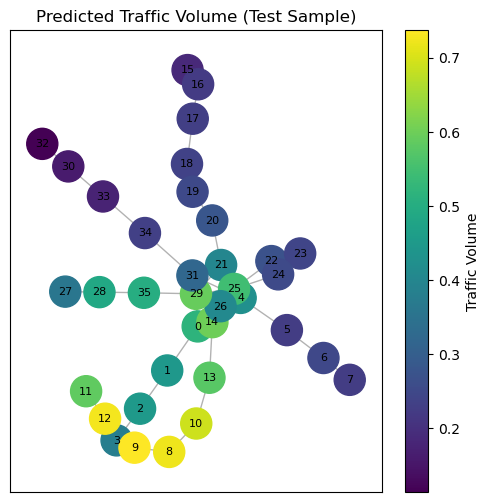

In [38]:
# Color nodes by predicted traffic
def plot_graph_colored(values, title):
    G = nx.from_numpy_array(adj)
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(6,6))
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=values,
        cmap="viridis",
        node_size=500
    )
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.colorbar(nodes, label="Traffic Volume")
    plt.title(title)
    plt.show()

plot_graph_colored(true, "Ground Truth Traffic Volume (Test Sample)")
plot_graph_colored(pred, "Predicted Traffic Volume (Test Sample)")
